Let's now work on the model to try and predict the damage level of each building. Let's start by importing the necessary libraries and the dataset containing the one-hot signatures created in the previous notebook.

In [1]:
import torch
import pandas as pd
import numpy as np
import pickle

from IPython.display import clear_output

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# dataframe = pd.read_csv('signature_dataframe.csv')
dataframe = pd.read_pickle('signature_condensed_dataframe.pkl')
dataframe.head()

,x,y
0,"[-0.8674214516922528, 0.5968959280707078, 1, 0...","[1, 0, 0, 0]"
1,"[-0.664418864464821, 0.4405339408980041, 1, 0,...","[1, 0, 0, 0]"
2,"[-0.21363849853229364, 0.19104651928789274, 0,...","[1, 0, 0, 0]"
3,"[-0.21115149773491346, 0.1691897795630536, 0, ...","[1, 0, 0, 0]"
4,"[-1.4160536746440862, 1.0894816994400685, 1, 0...","[0, 1, 0, 0]"


Let's now define the model as a simple fully connected neural network. We write the class so that the hidden layers size and depth of the model can be easily modified.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self, input_len, output_len, hidden_dim, depth):
        super(FullyConnectedNN, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.fc_layers = nn.Sequential()
        
        
        for i in range(depth):
            in_features = self.input_len if i == 0 else self.hidden_dim
            self.fc_layers.add_module(f"fc{i}", nn.Linear(in_features, self.hidden_dim))
            self.fc_layers.add_module(f"relu{i}", nn.ReLU())
        
        self.classifier = nn.Sequential(nn.Linear(self.hidden_dim, self.output_len), nn.Softmax(dim=1))
        self.to(DEVICE)
        # print number of parameters
        print(f"Number of parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad)}")
        
    def forward(self, x):
        x = self.fc_layers(x.view(-1, self.input_len))
        x = self.classifier(x)
        return x


Next we define a CustomDataset class that will be used to load the data in batches. This takes the pandas dataframe as input and returns the one-hot signatures and damage levels as tensors.
This class is necessary in order to use the PyTorch DataLoader class.

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get the label for the current sample
        label = torch.Tensor(self.dataframe['y'].iloc[idx]).to(DEVICE)
        
        # Get the input for the current sample
        input = torch.Tensor(self.dataframe['x'].iloc[idx]).to(DEVICE)
        
        return input, label
    
    def train_test_split(self, train_size=0.8):
        train_size = int(train_size * len(self))
        test_size = len(self) - train_size
        return torch.utils.data.random_split(self, [train_size, test_size])





We now split the data into training and testing sets. We use 80% of the data for training and 20% for testing.
We also define the data loaders for the training and testing sets.

In [5]:
dataset = CustomDataset(dataframe)
train_dataset, test_dataset = dataset.train_test_split()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

Now let's calculate a list of weights to be used in the loss function to account for the class imbalance so that the model does not overfit to the majority class.

In [6]:
# Get weights for each class for balancing loss function

N_CLASSES = len(dataset[0][1])
# get support of each class in dataframe
scalar_df = dataframe['y'].apply(lambda x: np.argmax(x))
weights = scalar_df.value_counts()

# sort weights by key
weights = weights.sort_index()
weights = weights.to_numpy()
weights = torch.Tensor(weights).to(DEVICE)

ALPHA = torch.ones(N_CLASSES).to(DEVICE)/weights


ALPHA

tensor([2.5090e-05, 3.9078e-04, 4.1254e-04, 2.6688e-04], device='cuda:0')

We also clamp these weight so that the model does not overfit to the minority classes.

In [7]:
# clamp alpha to avoid exessive weight on rare classes
ALPHA = ALPHA.clamp(min(ALPHA).item(), max(ALPHA).item()) # multiply by 0.x to avoid overfitting
# normalize alpha
ALPHA = ALPHA/ALPHA.sum()
ALPHA

tensor([0.0229, 0.3568, 0.3767, 0.2437], device='cuda:0')

For the loss function we use a modified version of a Focal Loss that allows to give weights to the different classes a priori. This is necessary because the dataset is highly imbalanced.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=0.05, logits=True, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
            
        
        
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else: 
            return F_loss
        
        
class FocalLossWithClassBalancing(nn.Module):
    def __init__(self, alpha=ALPHA, gamma=2, reduction='elementwise_mean'): # <----------------------------- alpha should be a list/tensor of length N_CLASSES
        super(FocalLossWithClassBalancing, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is None:
            self.alpha = torch.ones(N_CLASSES, dtype=torch.float32).to(DEVICE)    
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
            
    def forward(self, inputs, targets, alpha=None):
        if alpha != None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)        
        
        BCE_loss = torch.clamp(targets * inputs, 0.000001, 1)

        F_loss = -(self.alpha.repeat(targets.shape[0], 1) * (1-BCE_loss)**self.gamma * BCE_loss.log())
        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss
        
class BalancedBCELoss(nn.Module):
    def __init__(self, alpha=ALPHA, reduction='elementwise_mean'):
        super(BalancedBCELoss, self).__init__()
        self.reduction = reduction
        if alpha is None:
            self.alpha = torch.ones(N_CLASSES, dtype=torch.float32).to(DEVICE)    
        else:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)
            
    def forward(self, inputs, targets, alpha=None):
        if alpha != None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32).to(DEVICE)        
        
        BCE_loss = torch.clamp(targets * inputs, 0.000001, 1)

        F_loss = -(self.alpha.repeat(targets.shape[0], 1) * BCE_loss.log())
        if self.reduction == 'elementwise_mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

And all that is left to do is to define the training loop and the testing loop. We make use of sklearn's metrics to calculate the accuracy, precision, recall and F1 score.

In [9]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm



from sklearn.metrics import classification_report

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, log_interval=10):
    model.to(DEVICE)
    train_losses = []
    test_losses = []
    test_scores = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        model.train()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            test_loss = 0
            y_true = []
            y_pred = []
            for data in test_dataloader:
                inputs, labels = data
                
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                
                labels = torch.argmax(labels, dim=1).view(-1, 1)
                predicted = torch.argmax(outputs.data, 1).view(-1, 1)
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(predicted.cpu().numpy().tolist())

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        test_score = classification_report(y_true, y_pred, zero_division=0, output_dict=False)
        
        test_scores.append(classification_report(y_true, y_pred, zero_division=0, output_dict=True))

        if (epoch + 1) % log_interval == 0:
            clear_output(wait=True)
            
            # plot training loss
            fig, ax = plt.subplots()
            ax.plot(train_losses, label='Training Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            
            # plot testing loss
            fig, ax = plt.subplots()
            ax.plot(test_losses, label='Testing Loss')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.legend()
            
            # plot average f1 score
            fig, ax = plt.subplots()
            ax.plot([score['macro avg']['f1-score'] for score in test_scores], label='Testing F1 Score Macro Avg')
            ax.plot([score['macro avg']['precision'] for score in test_scores], label='Testing Precision Score Macro Avg')
            ax.plot([score['macro avg']['recall'] for score in test_scores], label='Testing Recall Score Macro Avg')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Score')
            ax.legend()
            
            # # plot average precision score
            # fig, ax = plt.subplots()
            # ax.plot([score['macro avg']['precision'] for score in test_scores], label='Testing Precision Score Macro Avg')
            # ax.set_xlabel('Epoch')
            # ax.set_ylabel('Precision Score')
            # ax.legend()
            
            # # plot average recall score
            # fig, ax = plt.subplots()
            # ax.plot([score['macro avg']['recall'] for score in test_scores], label='Testing Recall Score Macro Avg')
            # ax.set_xlabel('Epoch')
            # ax.set_ylabel('Recall Score')
            # ax.legend()
            
            # plot f1 score for each class
            fig, ax = plt.subplots()
            for i in range(N_CLASSES):
                ax.plot([score[str(i)]['f1-score'] for score in test_scores], label=f'Class {i}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('F1 Score')
            ax.legend()
            
            plt.show()
        
        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} \nTest Score:\n {test_score} ")



In this cell we either define a new model or load a previously trained one.

In [10]:
model = FullyConnectedNN(input_len=len(dataset[0][0]), output_len=len(dataset[0][1]), hidden_dim=15, depth=8)

# model = pickle.load(open('model.pkl', 'rb'))

Number of parameters: 2809


Lastly, we train the model and save it.

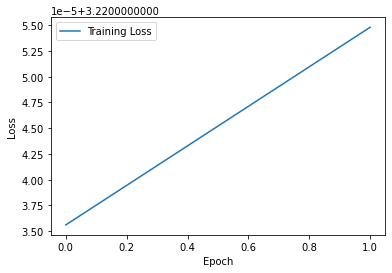

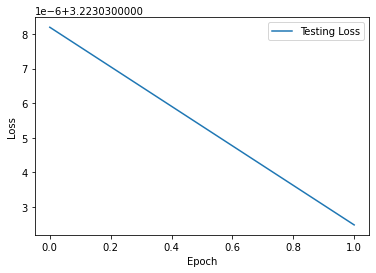

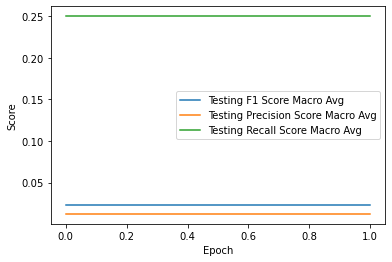

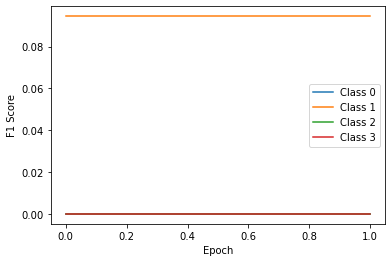

  0%|          | 2/500 [00:31<2:11:03, 15.79s/it]

Epoch 2/500: Training Loss: 3.2201 Test Loss: 3.2230 
Test Score:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7994
           1       0.05      1.00      0.09       482
           2       0.00      0.00      0.00       491
           3       0.00      0.00      0.00       751

    accuracy                           0.05      9718
   macro avg       0.01      0.25      0.02      9718
weighted avg       0.00      0.05      0.00      9718
 


In [11]:
train(model, train_loader, test_loader, BalancedBCELoss(), optim.Adam(model.parameters(), lr=0.0001), num_epochs=500, log_interval=1)

In [ ]:

# save model
pickle.dump(model, open('model_narrow_condensed.pkl', 'wb'))